In [1]:
import sys
import os
import csv
import pandas as pd
import html
import argparse
import codecs
import numpy as np
import random
import math as m
import itertools
import argparse
import re

import collections
from collections import OrderedDict
from collections import defaultdict
from itertools import chain

from matplotlib.ticker import FormatStrFormatter
#from ccdc.descriptors import CrystalDescriptors,GeometricDescriptors, MolecularDescriptors
#from ccdc._lib import MathsLib
#from ccdc.io import EntryReader
#from ccdc.io import MoleculeReader
#from ccdc.io import CrystalReader
#from ccdc.io import CrystalWriter
import warnings
warnings.filterwarnings('ignore')

import matplotlib
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
basedir = "C:/Users/wellawat/Downloads/molecule_XXIII"
rugosities = np.load(basedir+'/mol_XXIII_rugosity.npy')

In [3]:
rug_dict = dict(((rugosities[i][0],rugosities[i][1]) for i in range(len(rugosities))))
rug_dict

{'XXIII-E-qha.cif': '-0.208448911591802',
 'XXIII-N18-qha.cif': '-0.2429848333127366',
 'XXIII-N31-qha.cif': '-0.21087378949206195',
 'XXIII-N39-qha.cif': '-0.2751363209381552',
 'XXIII-N4-qha.cif': '-0.1894836326729823',
 'XXIII-N42-qha.cif': '-0.18748901912338767',
 'XXIII-N6-qha.cif': '-0.2010508186167091',
 'XXIII-N70-qha.cif': '-0.24938843206089073',
 'XXIII-N85-qha.cif': '-0.24122254770789645'}

In [3]:
map_dict = {'XXIII-E-qha.cif':'FormE',
           'XXIII-N39-qha.cif': 'FormD',
           'XXIII-N4-qha.cif': 'FormB',
           'XXIII-N6-qha.cif': 'FormC',
           'XXIII-N70-qha.cif': 'GM',
            "XXIII-N85-qha.cif": 'FormA',
           'XXIII-N18-qha.cif':None,
           'XXIII-N31-qha.cif':None,
           'XXIII-N42-qha.cif':None}

rel_free_dict = {'XXIII-E-qha.cif':1.4,
           'XXIII-N39-qha.cif': 4.3,
           'XXIII-N4-qha.cif': 2.5,
           'XXIII-N6-qha.cif': 1.5,
           'XXIII-N70-qha.cif': 0,
            "XXIII-N85-qha.cif": 4.1,
           'XXIII-N18-qha.cif':2.2,
           'XXIII-N31-qha.cif':2.1,
           'XXIII-N42-qha.cif':3.0}

rug_dict={'XXIII-E-qha.cif': -0.208448911591802,
 'XXIII-N18-qha.cif': -0.2429848333127366,
 'XXIII-N31-qha.cif': -0.21087378949206195,
 'XXIII-N39-qha.cif': -0.2751363209381552,
 'XXIII-N4-qha.cif': -0.1894836326729823,
 'XXIII-N42-qha.cif': -0.18748901912338767,
 'XXIII-N6-qha.cif': -0.2010508186167091,
 'XXIII-N70-qha.cif': -0.24938843206089073,
 'XXIII-N85-qha.cif': -0.24122254770789645}     

In [22]:
def create_init_df(scf_file,cols=['filename', 'energy']):
    data = pd.read_csv(scf_file, sep=',', header=None, names=cols) 
    outname = scf_file.replace('.txt','.csv')
    nrows = data.shape[0]
    
    for i in range(nrows):
        fname = data['filename'][i].split('/')[-1]
        data['filename'][i] = fname.split('.')[0]

    data.to_csv(outname,index=False)
    return outname

In [23]:
outcsv = create_init_df(f'mol23_scf_done.txt',cols=['filename', 'energy'])
df = pd.read_csv(outcsv)
df.head()

,filename,energy
0,"XXIII-E-qha_m_1_gas_free,-1935",NaN
1,"XXIII-E-qha_m_1_gas_restricted,-1935",NaN
2,"XXIII-E-qha_m_1_water_free,-1935",NaN
3,"XXIII-E-qha_m_1_water_restricted,-1935",NaN
4,"XXIII-E-qha_m_2_gas_free,-1935",NaN


In [53]:
gas_del_confE = defaultdict(list)
wat_del_confE = defaultdict(list)
file_names = list(df['filename'])

#gm_energy = df.loc[df['filename'] == f'XXIII-N70-qha_m_1_{phase}_free', 'energy'].iloc[0]
for file in file_names:
    splt = file.split('_')
    job = splt[-1]
    phase = splt[-2]
    key = file.split('_')[0]
    if job == 'free':
        if phase == 'gas':
            gm = 'XXIII-N70-qha_m_1_gas_free'
            conf_gm =  df.loc[df['filename'] == gm, 'energy'].iloc[0]
            conf_e2 =  df.loc[df['filename'] == file, 'energy'].iloc[0]
            delta_conf = (conf_e2-conf_gm)*2625.5
            gas_del_confE[key].append(delta_conf)

            
        else:
            gm = 'XXIII-N70-qha_m_1_water_free'
            conf_gm =  df.loc[df['filename'] == gm, 'energy'].iloc[0]
            conf_e2 =  df.loc[df['filename'] == file, 'energy'].iloc[0]
            delta_conf = (conf_e2-conf_gm)*2625.5
            wat_del_confE[key].append(delta_conf)
            

#keep the max E component            
gas_confE_final = {}
for k,v in gas_del_confE.items():
    gas_confE_final[k] = max(v)

    
wat_confE_final = {}
for k,v in wat_del_confE.items():
    wat_confE_final[k] = max(v)

In [54]:
def save_conf_df(conf_dict,rug_dict,rele_dict,phase):
    
    rugosities = []
    rel_free = []
    structures = list(conf_dict.keys())
    df1 = pd.DataFrame.from_dict(conf_dict, orient='index',columns=['Delta_conformational_energy(kJ/mol)'])
    df1.reset_index(inplace=True)
    df1 = df1.rename(columns = {'index':'Refcode'})
    
    for s in structures:
        cif_name = s.split('_')[0]+'.cif'
        rugosities.append(rug_dict[cif_name])
        rel_free.append(rele_dict[cif_name])
        
    df1['Rel_free_energy'] = rel_free
    df1['Rugosity']  = rugosities
    
    df1.to_csv(f'{basedir}/{phase}_coformational_energy.csv',index=False,header=True)

In [55]:
save_conf_df(gas_confE_final,rug_dict,rel_free_dict,phase='Gas') 

In [56]:
save_conf_df(wat_confE_final,rug_dict,rel_free_dict,phase='Water') 

## Compute strain energies and keep the max component


In [63]:
gas_del_strainE = defaultdict(list)
wat_del_strainE = defaultdict(list)
file_names = list(df['filename'])


#gm_energy = df.loc[df['filename'] == f'XXIII-N70-qha_m_1_{phase}_free', 'energy'].iloc[0]
for file in file_names:
    splt = file.split('_')
    job = splt[-1]
    phase = splt[-2]
    key = splt[0]
    if job == 'free':
        fileR = file.replace('free','restricted')
        conf_e =  df.loc[df['filename'] == file, 'energy'].iloc[0]
        crys_e =  df.loc[df['filename'] == fileR, 'energy'].iloc[0]
        strain_e = (crys_e - conf_e)*2625.5
        
        ## GM strain
        gm_xr  = df.loc[df['filename'] == f'XXIII-N70-qha_m_1_{phase}_free', 'energy'].iloc[0]
        gm_r  = df.loc[df['filename'] == f'XXIII-N70-qha_m_1_{phase}_restricted', 'energy'].iloc[0]
        gm_strain = (gm_r - gm_xr)*2625.5
        rel_strain = strain_e - gm_strain
        
        if phase == 'gas':    
            gas_del_strainE[key].append(rel_strain)
        else:
            wat_del_strainE[key].append(rel_strain)

delta_gas_strain_final = {}
for k,v in gas_del_strainE.items():
    delta_gas_strain_final[k] = max(v)
    
delta_wat_strain_final = {}
for k,v in wat_del_strainE.items():
    delta_wat_strain_final[k] = max(v)

In [70]:
def save_strain_df(strain_dict,rug_dict,rele_dict,phase):
    
    rugosities = []
    rel_free = []
    structures = list(strain_dict.keys())
    df1 = pd.DataFrame.from_dict(strain_dict, orient='index',columns=['Delta_strain_energy(kJ/mol)'])
    df1.reset_index(inplace=True)
    df1 = df1.rename(columns = {'index':'Refcode'})
    
    for s in structures:
        cif_name = s.split('_')[0]+'.cif'
        rugosities.append(rug_dict[cif_name])
        rel_free.append(rele_dict[cif_name])
        
    df1['Rel_free_energy'] = rel_free
    df1['Rugosity']  = rugosities
    
    df1.to_csv(f'{basedir}/{phase}_strain_energy.csv',index=False,header=True)

In [71]:
save_strain_df(delta_gas_strain_final ,rug_dict,rel_free_dict,phase='Gas')

In [72]:
save_strain_df(delta_wat_strain_final ,rug_dict,rel_free_dict,phase='Water')

## combine two dataframes

In [91]:
phases = ['Gas','Water']

for phase in phases:
    print(phase)
    df_c = pd.read_csv(f'{basedir}/{phase}_coformational_energy.csv')
    df_s = pd.read_csv(f'{basedir}/{phase}_strain_energy.csv')

    result = pd.concat([df_c, df_s], axis=1, join="inner")
    result = result.loc[:,~result.columns.duplicated()].copy()
    print(f'{basedir}/{phase}_all_energies.csv')
    result.to_csv(f'{basedir}/{phase}_all_energies.csv',index=False,header=True)

Gas
C:/Users/wellawat/Downloads/molecule_XXIII/Gas_all_energies.csv
Water
C:/Users/wellawat/Downloads/molecule_XXIII/Water_all_energies.csv


## Plot energies 

In [ ]:
 '''gridspec_kw={
        # set the height ratios between the rows
        "height_ratios": [1, 1],
        # set the width ratios between the columns
        "width_ratios": [1, 2, 1],
        "wspace": 0.04,
        "hspace": 0.05,
    }'''

In [2]:
exp_dict = {"XXIII-N85-qha": 'FormA',
            'XXIII-N4-qha': 'FormB',
            'XXIII-N6-qha': 'FormC',
            'XXIII-N39-qha': 'FormD',
            'XXIII-E-qha':'FormE',
            'XXIII-N70-qha': 'GM'}
csp_dict = {'XXIII-N18-qha':'CSP_I',
       'XXIII-N31-qha':'CSP_II',
       'XXIII-N42-qha':'CSP_III'}

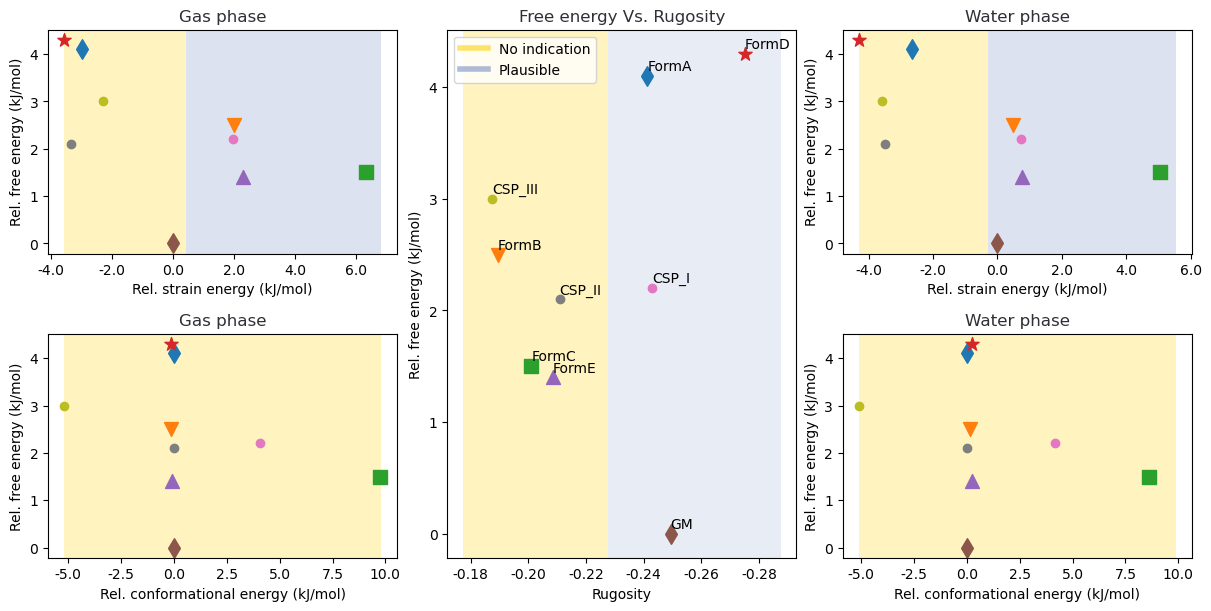

In [4]:
c_labels = ['D','E']
s_labels = ['A','C',]
#titles_small = ['Gas phase','Water phase']
solvents = ['Gas', 'Water']
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]

axd = plt.figure(figsize=(12,6),constrained_layout=True).subplot_mosaic(
    """
    ABC
    DBE
    """
)

for i in range(2):
    phase = solvents[i]
    df = pd.read_csv(f'{phase}_all_energies.csv')
    free_e = list(df['Rel_free_energy'])
    strain_e = list(df['Delta_strain_energy(kJ/mol)'])
    conf_e = list(df['Delta_conformational_energy(kJ/mol)'])
    rugosity = list(df['Rugosity'])
    title = f'{phase} phase'
    gm_conf = df.loc[df['Refcode'] == f'XXIII-N70-qha', 'Delta_conformational_energy(kJ/mol)'].iloc[0]
    gm_strain = df.loc[df['Refcode'] == f'XXIII-N70-qha', 'Delta_strain_energy(kJ/mol)'].iloc[0]
    gm_rug =  df.loc[df['Refcode'] == f'XXIII-N70-qha', 'Rugosity'].iloc[0]
    gm_free = df.loc[df['Refcode'] == f'XXIII-N70-qha', 'Rel_free_energy'].iloc[0]
    
    mct = 0
    for k,v in exp_dict.items():
        ex_conf = df.loc[df['Refcode'] == k, 'Delta_conformational_energy(kJ/mol)'].iloc[0]
        ex_strain = df.loc[df['Refcode'] == k, 'Delta_strain_energy(kJ/mol)'].iloc[0]
        ex_rug =  df.loc[df['Refcode'] == k, 'Rugosity'].iloc[0]
        ex_free = df.loc[df['Refcode'] == k, 'Rel_free_energy'].iloc[0]
        axd[s_labels[i]].scatter(ex_strain, ex_free, marker=markers[mct],s=100, label=v)
        #axd[s_labels[i]].annotate(v, (ex_strain, ex_free + 0.2))
        axd[c_labels[i]].scatter(ex_conf, ex_free,marker=markers[mct],s=100,label=v)
        #axd[c_labels[i]].annotate(v, (ex_conf, ex_free+0.2))
        
        if i==1:
            axd['B'].scatter(ex_rug, ex_free,marker=markers[mct],s=100,label=v)
            axd['B'].annotate(v, (ex_rug, ex_free + 0.05))
        mct +=1

    for k,v in csp_dict.items():
        #if k =='XXIII-N42-qha':
        #    lab = 'CSP'
        #else: lab = v
        csp_conf = df.loc[df['Refcode'] == k, 'Delta_conformational_energy(kJ/mol)'].iloc[0]
        csp_strain = df.loc[df['Refcode'] == k, 'Delta_strain_energy(kJ/mol)'].iloc[0]
        csp_rug = df.loc[df['Refcode'] == k, 'Rugosity'].iloc[0] 
        csp_free = df.loc[df['Refcode'] == k, 'Rel_free_energy'].iloc[0]

        axd[s_labels[i]].scatter(csp_strain, csp_free,label=v)
        #axd[s_labels[i]].annotate(v, (csp_strain, csp_free + 0.2))
        axd[c_labels[i]].scatter(csp_conf, csp_free,label=v)
        #axd[c_labels[i]].annotate(v, (csp_conf, csp_free+0.2))
        
        if i==1:
            axd['B'].scatter(csp_rug, csp_free)
            axd['B'].annotate(v, (csp_rug, csp_free + 0.05))


    #for xs, ys, ms in zip(strain_e,free_e,markers):
     #   axd[s_labels[i]].scatter(xs, ys)#, marker=ms,s=50)
        
    #for xc, yc, mc in zip(conf_e,free_e,markers):
    #    axd[c_labels[i]].scatter(xc, yc)#, marker=mc,s=50)
   
    axd[c_labels[i]].set_title(title,c='#2e3036')
    axd[s_labels[i]].set_title(title,c='#2e3036')
    axd[s_labels[i]].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    axd[c_labels[i]].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    axd[c_labels[i]].set_xlabel('Rel. conformational energy (kJ/mol)')
    axd[c_labels[i]].set_ylabel('Rel. free energy (kJ/mol)')
    axd[s_labels[i]].set_xlabel('Rel. strain energy (kJ/mol)')
    axd[s_labels[i]].set_ylabel('Rel. free energy (kJ/mol)')
    
    '''axd[s_labels[i]].annotate("GM",
                xy=(gm_strain, gm_free), xycoords='data',
                xytext=(gm_strain,gm_free+0.5), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))
    axd[c_labels[i]].annotate("GM",
                xy=(gm_conf, gm_free), xycoords='data',
                xytext=(gm_conf,gm_free+0.5), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))'''
    min_strain = min(list(df['Delta_strain_energy(kJ/mol)']))
    min_conf = min(list(df['Delta_conformational_energy(kJ/mol)']))
    max_strain = max(list(df['Delta_strain_energy(kJ/mol)']))
    max_conf = max(list(df['Delta_conformational_energy(kJ/mol)']))
    axd[s_labels[i]].axvspan(min_strain, min_strain+4.0, facecolor='#ffd92f',alpha=0.3,zorder=-1)
    axd[c_labels[i]].axvspan(min_conf, min_conf+15, facecolor='#ffd92f',alpha=0.3,zorder=-1)
    axd[s_labels[i]].axvspan(min_strain+4.0, max_strain+.5, facecolor='#8da0cb',alpha=0.3,zorder=-1)
    #axd[c_labels[i]].axvspan(min_conf+15,max_conf, facecolor='#8da0cb',alpha=0.3,zorder=-1)
    
axd['B'].set_title('Free energy Vs. Rugosity', c='#2e3036')

#for x, y, m in zip(rugosity,free_e,markers):
#    axd['B'].scatter(x, y)#, marker=m,s=50)

axd['B'].set_xlabel('Rugosity')
axd['B'].set_ylabel('Rel. free energy (kJ/mol)')
axd['B'].invert_xaxis()
axd['B'].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
axd['B'].axvspan(max(rugosity), max(rugosity)-0.04, facecolor='#ffd92f',alpha=0.3,zorder=-1)
axd['B'].axvspan(max(rugosity), max(rugosity)+0.01, facecolor='#ffd92f',alpha=0.3,zorder=-1)
axd['B'].axvspan(max(rugosity)-0.04, max(rugosity)-0.1, facecolor='#8da0cb',alpha=0.2,zorder=-1)
'''axd['B'].annotate("GM",
                xy=(gm_rug, gm_free), xycoords='data',
                xytext=(gm_rug,gm_free+0.5), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))'''
#axd['B'].axvspan(max(rugs)-0.2, min(rugs), facecolor='#f02424',alpha=0.2,zorder=-1)
#
custom_lines = [Line2D([0], [0], color='#ffd92f', alpha =0.7,lw=4),
                Line2D([0], [0], color='#8da0cb',alpha =0.7, lw=4)]

axd['B'].legend(custom_lines, ['No indication', 'Plausible'],loc='upper left',facecolor='w')

#axd['C'].legend(bbox_to_anchor=(1.36, 1), loc='upper right')
plt.savefig(f'Mol23_color_coded.png', dpi=300, facecolor='w')
plt.show()

## plot strain vs rugosity

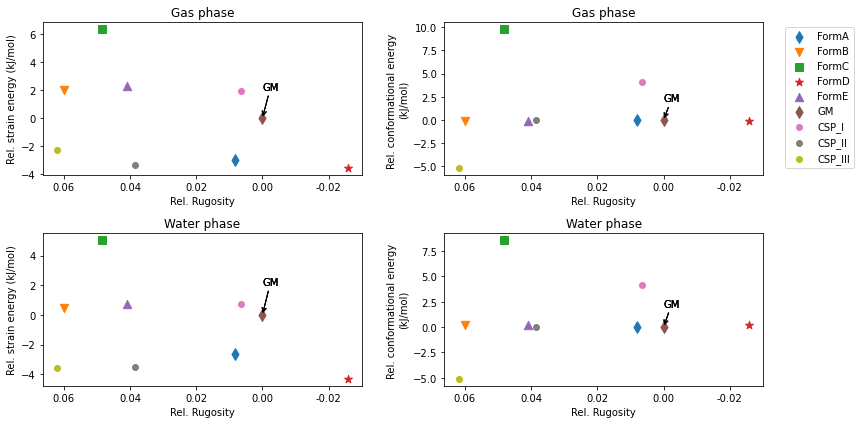

In [86]:
solvents = ['Gas','Water']
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
fig, axes = plt.subplots(2, 2,figsize=(12,6))
ax = axes.ravel()
for i in range(4):
    row = i//2
    phase = solvents[row]
    df = pd.read_csv(f'{basedir}/{phase}_all_energies.csv')
    all_rugs = list(df['Rugosity'])
    mx_r = max(all_rugs)
    mn_r = max(all_rugs)
    all_c = list(df['Delta_conformational_energy(kJ/mol)'])
    all_s = list(df['Delta_strain_energy(kJ/mol)'])
    title = f'{phase} phase'
    gm_conf = df.loc[df['Refcode'] == f'XXIII-N70-qha', 'Delta_conformational_energy(kJ/mol)'].iloc[0]
    gm_strain = df.loc[df['Refcode'] == f'XXIII-N70-qha', 'Delta_strain_energy(kJ/mol)'].iloc[0]
    gm_rug =  df.loc[df['Refcode'] == f'XXIII-N70-qha', 'Rugosity'].iloc[0]
 
    
     
    mct = 0
    for k,v in exp_dict.items():
        ex_conf = df.loc[df['Refcode'] == k, 'Delta_conformational_energy(kJ/mol)'].iloc[0]
        ex_strain = df.loc[df['Refcode'] == k, 'Delta_strain_energy(kJ/mol)'].iloc[0]
        ex_rug =  df.loc[df['Refcode'] == k, 'Rugosity'].iloc[0] -gm_rug
        if i%2 == 0:
            ax[i].scatter(ex_rug, ex_strain, marker=markers[mct],s=70, label=v)
            rect1 = matplotlib.patches.Rectangle((mx_r+0.01,min(all_s)-0.5), -0.05, 4+0.5, color='#f4cae4',zorder=-1,alpha=0.3)
            rect2 = matplotlib.patches.Rectangle((mx_r-0.04,min(all_s)-0.5),-0.06,4+0.5,color='#fdcdac',zorder=-1,alpha=0.3)
            rect3 = matplotlib.patches.Rectangle((mx_r+0.01,min(all_s)+4.0), -0.05, 8, color='#cbd5e8',zorder=-1,alpha=0.3)
            rect4 = matplotlib.patches.Rectangle((mx_r-0.04,min(all_s)+4),-0.06,8,color='#b3e2cd',zorder=-1,alpha=0.3)
            #ax[i].add_patch(rect1)
            #ax[i].add_patch(rect2)
            #ax[i].add_patch(rect3)
            #ax[i].add_patch(rect4)
        else:
            ax[i].scatter(ex_rug, ex_conf, marker=markers[mct],s=70, label=v)
            rect1 = matplotlib.patches.Rectangle((mx_r+0.01,min(all_c)-0.5), -0.05, 15+0.5, color='#f4cae4',zorder=-1,alpha=0.3)
            rect2 = matplotlib.patches.Rectangle((mx_r-0.04,min(all_c)-0.5),-0.06,15+0.5,color='#fdcdac',zorder=-1,alpha=0.3)
            rect3 = matplotlib.patches.Rectangle((mx_r+0.01,min(all_c)+15), -0.05, 2, color='#cbd5e8',zorder=-1,alpha=0.3)
            rect4 = matplotlib.patches.Rectangle((mx_r-0.04,min(all_c)+15),-0.06,2,color='#b3e2cd',zorder=-1,alpha=0.3)
            #ax[i].add_patch(rect1)
            #ax[i].add_patch(rect2)
            #ax[i].add_patch(rect3)
            #ax[i].add_patch(rect4)
        mct +=1

    
    for k,v in csp_dict.items():
        csp_conf = df.loc[df['Refcode'] == k, 'Delta_conformational_energy(kJ/mol)'].iloc[0]
        csp_strain = df.loc[df['Refcode'] == k, 'Delta_strain_energy(kJ/mol)'].iloc[0]
        csp_rug = df.loc[df['Refcode'] == k, 'Rugosity'].iloc[0] - gm_rug
        if i%2 == 0:
            ax[i].scatter(csp_rug, csp_strain, label=v)
            ax[i].annotate("GM",
                xy=(gm_rug-gm_rug, gm_strain-gm_strain), xycoords='data', 
                xytext=(gm_rug-gm_rug,2.0), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))
            ax[i].set_ylabel('Rel. strain energy (kJ/mol)')
        else:
            ax[i].scatter(csp_rug, csp_conf, label=v)
            ax[i].annotate("GM",
                xy=(gm_rug-gm_rug, gm_conf-gm_conf), xycoords='data',
                xytext=(gm_rug-gm_rug,gm_conf+2.0-gm_conf), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))
            ax[i].set_ylabel('Rel. conformational energy \n(kJ/mol)')
    
    #ax[i].axvspan(mx_r, mx_r-0.04, facecolor='#ffd92f',alpha=0.3,zorder=-1)
    #ax[i].axvspan(mx_r, mx_r+0.01, facecolor='#ffd92f',alpha=0.3,zorder=-1)
    #ax[i].axvspan(mx_r-0.04, mx_r-0.1, facecolor='#8da0cb',alpha=0.2,zorder=-1)
    ax[i].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax[i].invert_xaxis()
    ax[i].set_xlabel('Rel. Rugosity')
    ax[i].set_title(title)

ax[1].legend(bbox_to_anchor=(1.3, 1), loc='upper right')
custom_lines = [Line2D([0], [0], color='#b3e2cd', alpha =0.7,lw=8),
                Line2D([0], [0], color='#fdcdac', alpha =0.7,lw=8),
               Line2D([0], [0], color='#cbd5e8', alpha =0.7,lw=8),
               Line2D([0], [0], color='#f4cae4', alpha =0.7,lw=8)]

#ax[3].legend(custom_lines, ['Both', 'Rugosity driven','Energy driven','No indication'],loc='upper right',bbox_to_anchor=(1.45, 1))
fig.tight_layout(w_pad=2.5)
#plt.savefig(f'{basedir}/Mol23_Rel_Rugosity_plot.png', dpi=300, facecolor='w')
fig.show()

In [107]:
## color by energy value
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


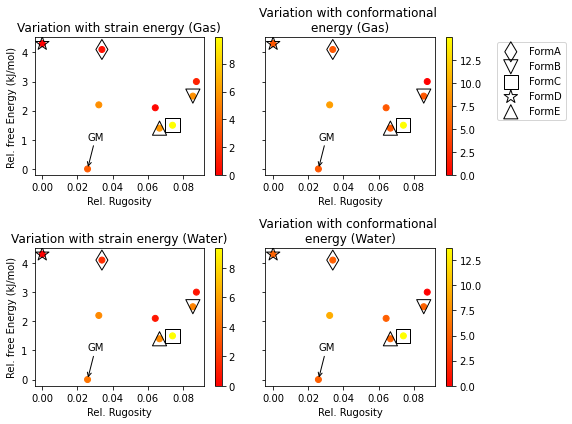

In [200]:
solvents = ['Gas','Water']
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
exp_dict = {"XXIII-N85-qha": 'FormA',
            'XXIII-N4-qha': 'FormB',
            'XXIII-N6-qha': 'FormC',
            'XXIII-N39-qha': 'FormD',
            'XXIII-E-qha':'FormE'}


new_o = ListedColormap(cm.get_cmap('Oranges')(np.linspace(0.3,1, 20)))
new_b = ListedColormap(cm.get_cmap('Blues')(np.linspace(0.3,1, 20)))
cmp = ListedColormap(cm.get_cmap('RdYlBu')(np.linspace(0.3,1, 20)))
fig, axes = plt.subplots(2, 2,figsize=(8,6),sharey = True)
ax = axes.ravel()
for i in range(4):
    row = i//2
    phase = solvents[row]
    df = pd.read_csv(f'{basedir}/{phase}_all_energies.csv')
    all_rugs = list(df['Rugosity'])
    norm_rugs = np.array(all_rugs) - min(all_rugs)
    all_c = list(df['Delta_conformational_energy(kJ/mol)'])
    all_free = list(df['Rel_free_energy'])
    norm_free = np.array(all_free) - min(all_free)
    all_s = list(df['Delta_strain_energy(kJ/mol)'])
    norm_c = np.array(all_c) - min(all_c)
    norm_s = np.array(all_s) - min(all_s)
    title = f'{phase} phase'
    ## create cmaps
    
    
    gm_conf = df.loc[df['Refcode'] == f'XXIII-N70-qha', 'Delta_conformational_energy(kJ/mol)'].iloc[0]
    gm_strain = df.loc[df['Refcode'] == f'XXIII-N70-qha', 'Delta_strain_energy(kJ/mol)'].iloc[0]
    gm_rug =  df.loc[df['Refcode'] == f'XXIII-N70-qha', 'Rugosity'].iloc[0]
    gm_rug -= min(all_rugs)
    gm_free = df.loc[df['Refcode'] == f'XXIII-N70-qha', 'Rel_free_energy'].iloc[0]
    

    ax[i].annotate("GM",
        xy=(gm_rug, gm_free-min(all_free)), xycoords='data',
        xytext=(gm_rug,gm_free+1.0), textcoords='data',
        arrowprops=dict(arrowstyle="->",
                        connectionstyle="arc3"))
    
 
    if i%2 == 0:
        sc = ax[i].scatter(norm_rugs, norm_free, c=norm_s, cmap='autumn')
        ax[i].set_title(f'Variation with strain energy ({phase})')
        fig.colorbar(sc,ax=ax[i])
        ax[i].set_ylabel('Rel. free Energy (kJ/mol)')
        
        
    
    else:
        sc = ax[i].scatter(norm_rugs, norm_free, c=norm_c, cmap='autumn')
        ax[i].set_title(f'Variation with conformational \nenergy ({phase})')
        fig.colorbar(sc,ax=ax[i])
        
    ax[i].set_xlabel('Rel. Rugosity')
    
    #ax[i].invert_xaxis()
    
    m = 0
    for k,v in exp_dict.items():
        ex_free = df.loc[df['Refcode'] == k, 'Rel_free_energy'].iloc[0]
        ex_rug =  df.loc[df['Refcode'] == k, 'Rugosity'].iloc[0] 
        ax[i].scatter(ex_rug-min(all_rugs), ex_free-min(all_free), marker=markers[m],s=200, label=v, edgecolor='k', linewidth=1, facecolor='none')
        m +=1
    


#ax[0].legend(custom_lines, ['Energy-No indication region','Energy driven region'],loc='upper right')
#ax[0].legend(custom_lines, ['Energy-No indication region','Energy driven region'],loc='upper right')
ax[1].legend(bbox_to_anchor=(1.8, 1), loc='upper right')
fig.tight_layout(w_pad=2.5)
fig.savefig(f'{basedir}/Mol23_hue_energy_plot.png', dpi=300, facecolor='w')
fig.show()

In [114]:
np.linspace(0.1,1, 10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
mct = 0
    for k,v in exp_dict.items():
        ex_conf = df.loc[df['Refcode'] == k, 'Delta_conformational_energy(kJ/mol)'].iloc[0]
        ex_strain = df.loc[df['Refcode'] == k, 'Delta_strain_energy(kJ/mol)'].iloc[0]
        ex_rug =  df.loc[df['Refcode'] == k, 'Rugosity'].iloc[0] 
        if i%2 == 0:
            ax[i].scatter(ex_rug, ex_strain, marker=markers[mct],s=70, label=v)
            rect1 = matplotlib.patches.Rectangle((mx_r+0.01,min(all_s)-0.5), -0.05, 4+0.5, color='#f4cae4',zorder=-1,alpha=0.3)
            rect2 = matplotlib.patches.Rectangle((mx_r-0.04,min(all_s)-0.5),-0.06,4+0.5,color='#fdcdac',zorder=-1,alpha=0.3)
            rect3 = matplotlib.patches.Rectangle((mx_r+0.01,min(all_s)+4.0), -0.05, 8, color='#cbd5e8',zorder=-1,alpha=0.3)
            rect4 = matplotlib.patches.Rectangle((mx_r-0.04,min(all_s)+4),-0.06,8,color='#b3e2cd',zorder=-1,alpha=0.3)
            ax[i].add_patch(rect1)
            ax[i].add_patch(rect2)
            ax[i].add_patch(rect3)
            ax[i].add_patch(rect4)
        else:
            ax[i].scatter(ex_rug, ex_conf, marker=markers[mct],s=70, label=v)
            rect1 = matplotlib.patches.Rectangle((mx_r+0.01,min(all_c)-0.5), -0.05, 15+0.5, color='#f4cae4',zorder=-1,alpha=0.3)
            rect2 = matplotlib.patches.Rectangle((mx_r-0.04,min(all_c)-0.5),-0.06,15+0.5,color='#fdcdac',zorder=-1,alpha=0.3)
            rect3 = matplotlib.patches.Rectangle((mx_r+0.01,min(all_c)+15), -0.05, 2, color='#cbd5e8',zorder=-1,alpha=0.3)
            rect4 = matplotlib.patches.Rectangle((mx_r-0.04,min(all_c)+15),-0.06,2,color='#b3e2cd',zorder=-1,alpha=0.3)
            ax[i].add_patch(rect1)
            ax[i].add_patch(rect2)
            ax[i].add_patch(rect3)
            ax[i].add_patch(rect4)
        mct +=1

    
    for k,v in csp_dict.items():
        csp_conf = df.loc[df['Refcode'] == k, 'Delta_conformational_energy(kJ/mol)'].iloc[0]
        csp_strain = df.loc[df['Refcode'] == k, 'Delta_strain_energy(kJ/mol)'].iloc[0]
        csp_rug = df.loc[df['Refcode'] == k, 'Rugosity'].iloc[0] 
        if i%2 == 0:
            ax[i].scatter(csp_rug, csp_strain, label=v)
            ax[i].annotate("GM",
                xy=(gm_rug, gm_strain), xycoords='data', 
                xytext=(gm_rug,gm_strain+2.0), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))
            ax[i].set_ylabel('Rel. strain energy (kJ/mol)')
        else:
            ax[i].scatter(csp_rug, csp_conf, label=v)
            ax[i].annotate("GM",
                xy=(gm_rug, gm_conf), xycoords='data',
                xytext=(gm_rug,gm_conf+2.0), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))
            ax[i].set_ylabel('Rel. conformational energy \n(kJ/mol)')
    
    #ax[i].axvspan(mx_r, mx_r-0.04, facecolor='#ffd92f',alpha=0.3,zorder=-1)
    #ax[i].axvspan(mx_r, mx_r+0.01, facecolor='#ffd92f',alpha=0.3,zorder=-1)
    #ax[i].axvspan(mx_r-0.04, mx_r-0.1, facecolor='#8da0cb',alpha=0.2,zorder=-1)
    ax[i].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax[i].invert_xaxis()
    ax[i].set_xlabel('Rugosity')
    ax[i].set_title(title)

#ax[3].legend(custom_lines, ['Both', 'Rugosity driven','Energy driven','No indication'],loc='upper right',bbox_to_anchor=(1.45, 1))
fig.tight_layout(w_pad=2.5)
#plt.savefig(f'{basedir}/Mol23_Rel_Rugosity_plot.png', dpi=300, facecolor='w')
fig.show()

In [13]:
df

,Refcode,Delta_conformational_energy(kJ/mol),Rel_free_energy,Rugosity,Delta_strain_energy(kJ/mol)
0,XXIII-E-qha,0.244145,1.4,-0.208449,0.767092
1,XXIII-N18-qha,4.176147,2.2,-0.242985,0.733722
2,XXIII-N31-qha,-0.000026,2.1,-0.210874,-3.498610
3,XXIII-N39-qha,0.242701,4.3,-0.275136,-4.308682
4,XXIII-N42-qha,-5.103814,3.0,-0.187489,-3.598116
5,XXIII-N4-qha,0.162650,2.5,-0.189484,0.486873
6,XXIII-N6-qha,8.603527,1.5,-0.201051,5.051620
7,XXIII-N70-qha,0.000000,0.0,-0.249388,0.000000
8,XXIII-N85-qha,0.000105,4.1,-0.241223,-2.656875
